In [7]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
from sklearn import datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso, SGDRegressor
from sklearn.neural_network import MLPRegressor
import pandas as pd
from numpy import asarray
import seaborn as sns

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def identity(x):
    return x

def identity_derivative(x):
    return np.ones_like(x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def mse(predictions, targets):
    return np.mean((predictions - targets) ** 2)

def mse_der(predictions, targets):
    return 2 * (predictions - targets) / targets.shape[0]

def r2_score(predictions, targets):
    ss_total = np.sum((targets - np.mean(targets)) ** 2)
    ss_residual = np.sum((targets - predictions) ** 2)
    return 1 - (ss_residual / ss_total)

def create_layers_batch(network_input_size, layer_output_sizes): 
    layers = []
    i_size = network_input_size
    for layer_output_size in layer_output_sizes:
        W = np.random.randn(i_size, layer_output_size) * np.sqrt(2 / (i_size + layer_output_size))
        b = np.zeros(layer_output_size)
        layers.append((W, b))
        i_size = layer_output_size
    return layers

def feed_forward_batch(inputs, layers, activation_funcs):
    a = inputs
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = (a @ W) + b
        a = activation_func(z)
    return a

def feed_forward_saver_batch(inputs, layers, activation_funcs):
    layer_inputs = []
    zs = []
    a = inputs  
    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)
        z = a @ W + b  
        a = activation_func(z)
        zs.append(z)
    return layer_inputs, zs, a 


def backpropagation_batch(inputs, layers, activation_funcs, targets, activation_ders, cost_der, lambda_reg=0.01):
    batch_size = inputs.shape[0]
    layer_inputs, zs, predict = feed_forward_saver_batch(inputs, layers, activation_funcs)
    layer_grads = [() for _ in layers]

    for i in reversed(range(len(layers))):
        layer_input, z, activation_der = layer_inputs[i], zs[i], activation_ders[i]
        
        if i == len(layers) - 1:
            dC_da = cost_der(predict, targets)
        else:
            (W, b) = layers[i + 1][:2]
            dC_da = dC_dz @ W.T 
        
        dC_dz = dC_da * activation_der(z)
        dC_dW = layer_input.T @ dC_dz / batch_size

        # Aggiungi il termine di regolarizzazione L2 al gradiente dei pesi
        W, b = layers[i]
        dC_dW += lambda_reg * W / batch_size  # Termine di regolarizzazione

        dC_db = np.mean(dC_dz, axis=0)
        
        layer_grads[i] = (dC_dW, dC_db)

    return layer_grads

def train_nn(inputs, targets, val_inputs, val_targets, layers, activation_funcs, activation_ders, learning_rate, epochs, batch_size, lambda_reg=0.01):
    num_samples = inputs.shape[0]
    training_metrics = {'mse': [], 'r2': []}
    validation_metrics = {'mse': [], 'r2': []}

    for epoch in range(epochs):
        # Shuffle the training data
        permutation = np.random.permutation(num_samples)
        inputs_shuffled = inputs[permutation]
        targets_shuffled = targets[permutation]

        # Training over batches
        for i in range(0, num_samples, batch_size):
            input_batch = inputs_shuffled[i:i + batch_size]
            target_batch = targets_shuffled[i:i + batch_size]

            # Backpropagation con regolarizzazione
            layer_grads = backpropagation_batch(input_batch, layers, activation_funcs, target_batch, activation_ders, mse_der, lambda_reg=lambda_reg)

            # Update weights and biases
            for j, (dC_dW, dC_db) in enumerate(layer_grads):
                W, b = layers[j]
                layers[j] = (W - learning_rate * dC_dW, b - learning_rate * dC_db)

        # Calculate metrics on training set
        predictions_train = feed_forward_batch(inputs, layers, activation_funcs)
        mse_train = mse(predictions_train, targets)
        r2_train = r2_score(predictions_train, targets)
        training_metrics['mse'].append(mse_train)
        training_metrics['r2'].append(r2_train)

        # Calculate metrics on validation set
        predictions_val = feed_forward_batch(val_inputs, layers, activation_funcs)
        mse_val = mse(predictions_val, val_targets)
        r2_val = r2_score(predictions_val, val_targets)
        validation_metrics['mse'].append(mse_val)
        validation_metrics['r2'].append(r2_val)

    return layers, training_metrics, validation_metrics

Val MSE: 0.0836, Val R²: 0.9386


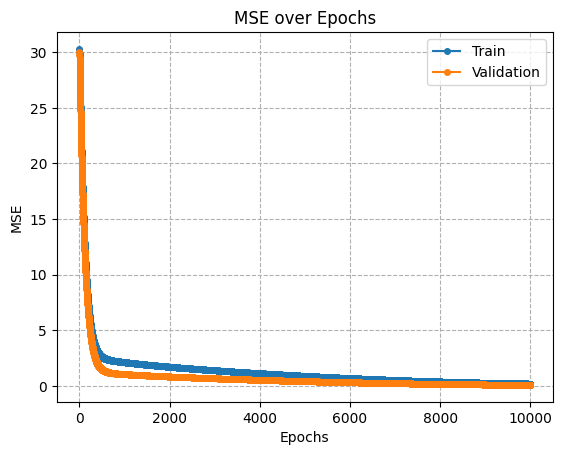

Test MSE: 0.3005, Test R²: 0.8889


In [3]:
# TEST CODE
import numpy as np
from sklearn.model_selection import train_test_split

# Synthetic dataset creation with a perfect linear relationship
np.random.seed(32)
n = 100
X = 2 * np.random.rand(n, 1)
y = 2 + 3 * X

# Splitting into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=32)

# Layers initialization with a simple architecture
layers = create_layers_batch(network_input_size=1, layer_output_sizes=[10, 1])

# Activation functions
activation_funcs = [sigmoid, identity]
activation_ders = [sigmoid_derivative, identity_derivative]

# Training parameters
learning_rate = 0.01
epochs = 10000  
batch_size = 32

# Training the network
trained_layers, training_metrics, validation_metrics = train_nn(X_train, y_train, X_val, y_val, layers, activation_funcs, activation_ders, learning_rate, epochs, batch_size)

print(f"Val MSE: {validation_metrics["mse"][-1]:.4f}, Val R²: {validation_metrics["r2"][-1]:.4f}")

plt.plot(range(1, len(training_metrics["mse"]) + 1), training_metrics["mse"], label="Train", marker='o', markersize=4)
plt.plot(range(1, len(validation_metrics["mse"]) + 1), validation_metrics["mse"], label="Validation", marker='o', markersize=4)
plt.title('MSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, which="both", linestyle='--')
plt.show()

# Testing on the test set
predictions_test = feed_forward_batch(X_test, trained_layers, activation_funcs)
mse_test = mse(predictions_test, y_test)
r2_test = r2_score(predictions_test, y_test)

print(f"Test MSE: {mse_test:.4f}, Test R²: {r2_test:.4f}")

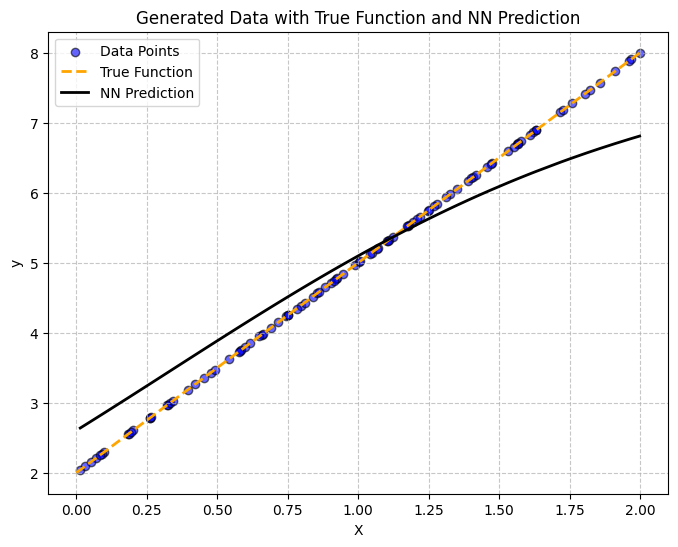

In [4]:
# Predict on the sorted input data
X_sorted = np.sort(X, axis=0)
y_pred = feed_forward_batch(X_sorted, trained_layers, activation_funcs)

# Plot the data points
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', alpha=0.6, edgecolor='k', label='Data Points')

# Plot the underlying true function (without noise)
X_real = np.linspace(0, 2, 200).reshape(-1, 1)
y_real = 2 + 3 * X_real
plt.plot(X_real, y_real, color='orange', linewidth=2, linestyle='--', label='True Function')

# Plot the predicted curve from the neural network
plt.plot(X_sorted, y_pred, color='black', linewidth=2, label='NN Prediction')

# Set plot details
plt.title('Generated Data with True Function and NN Prediction')
plt.xlabel('X')
plt.ylabel('y')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

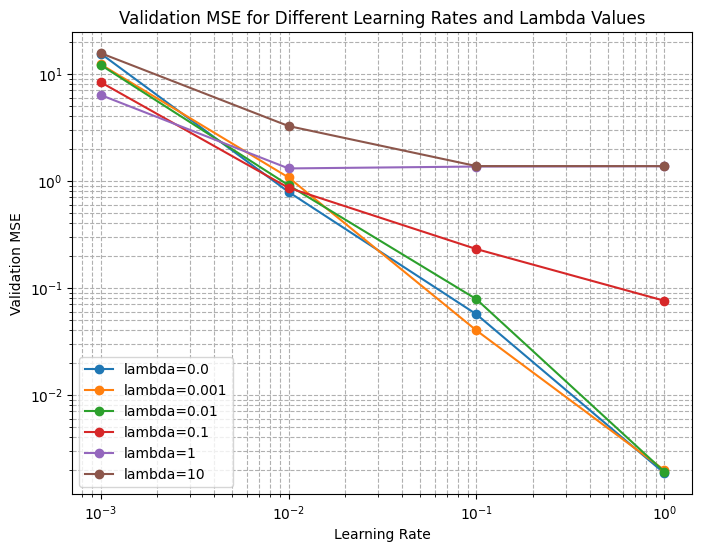

In [5]:
# lambda e learning rate
lambda_values = [0.0, 0.001, 0.01, 0.1, 1, 10]
learning_rates = [0.001, 0.01, 0.1, 1]
results = []

for lambda_reg in lambda_values:
    for lr in learning_rates:
        
        layers = create_layers_batch(network_input_size=1, layer_output_sizes=[10, 1])

        _, _, validation_metrics = train_nn(
            inputs=X_train, 
            targets=y_train, 
            val_inputs=X_val, 
            val_targets=y_val, 
            layers=layers, 
            activation_funcs=activation_funcs, 
            activation_ders=activation_ders, 
            learning_rate=lr, 
            epochs=1000, 
            batch_size=32,
            lambda_reg=lambda_reg  
        )
        
        final_mse_val = validation_metrics['mse'][-1]
        results.append((lambda_reg, lr, final_mse_val))

results = np.array(results)

plt.figure(figsize=(8, 6))

# Plotta MSE  learning rate e lambda
for lambda_reg in lambda_values:
    subset = results[results[:, 0] == lambda_reg]  # Filtra per lambda
    plt.plot(subset[:, 1], subset[:, 2], marker='o', label=f'lambda={lambda_reg}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Validation MSE")
plt.title("Validation MSE for Different Learning Rates and Lambda Values")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.show()

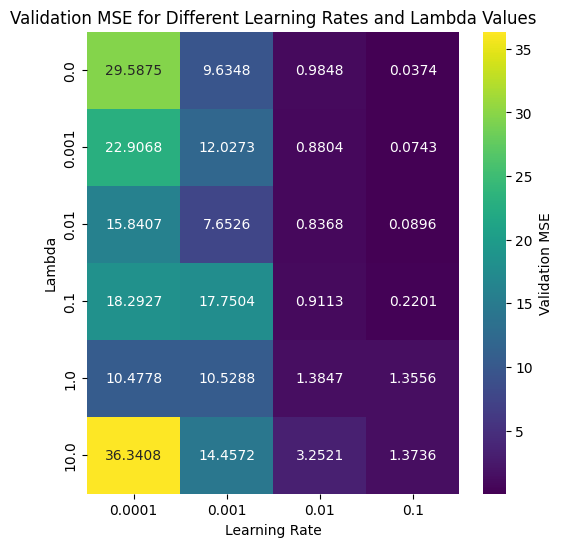

In [8]:
# lambda e learning rate
lambda_values = [0.0, 0.001, 0.01, 0.1, 1, 10]
learning_rates = [0.0001, 0.001, 0.01, 0.1]
results = []

for lambda_reg in lambda_values:
    for lr in learning_rates:
        
        layers = create_layers_batch(network_input_size=1, layer_output_sizes=[10, 1])

        _, _, validation_metrics = train_nn(
            inputs=X_train, 
            targets=y_train, 
            val_inputs=X_val, 
            val_targets=y_val, 
            layers=layers, 
            activation_funcs=activation_funcs, 
            activation_ders=activation_ders, 
            learning_rate=lr, 
            epochs=1000, 
            batch_size=32,
            lambda_reg=lambda_reg  
        )

        final_mse_val = validation_metrics['mse'][-1]
        results.append((lambda_reg, lr, final_mse_val))

# DataFrame 
results_df = pd.DataFrame(results, columns=['lambda', 'learning_rate', 'mse'])
heatmap_data = results_df.pivot(index="lambda", columns="learning_rate", values="mse")

# Plot heatmap
plt.figure(figsize=(6,6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'Validation MSE'})
plt.title("Validation MSE for Different Learning Rates and Lambda Values")
plt.xlabel("Learning Rate")
plt.ylabel("Lambda")
plt.show()